# The Effect of Finite Model Bandwidth on Predicted Step Response

Original author: David Banas <capn.freako@gmail.com>  
Original date: July 15, 2016

Copyright &#169; David Banas; all rights reserved World wide.

In [1]:
import time;

gmtime = time.asctime( time.gmtime(time.time()) )
print "Notebook last run:", gmtime, "GMT"


Notebook last run: Sat Jul 16 14:49:12 2016 GMT


## Table of Contents <a name="toc"/>

[Introduction](#introduction)  
[Results](#results)  
[Observations](#observations)  
[Conclusion](#conclusion)  
[Acknowledgements](#acknowledgements)

## Introduction <a name="introduction"/>

This [IPython](http://ipython.readthedocs.io/en/stable/) [Jupyter Notebook](http://jupyter.org) investigates the effect of finite bandwidth of channel models constructed analytically, in the frequency domain, on the estimated channel step response, calculated using the Fourier transform.

## Results <a name="results"/>

I chose a simple single pole low pass response, as my test vehicle, because it's response is easy to predict and judge the correctness of.

(2550.4507034144863,
 2569.5492965855137,
 -0.20000000000000001,
 1.2000000000000002)

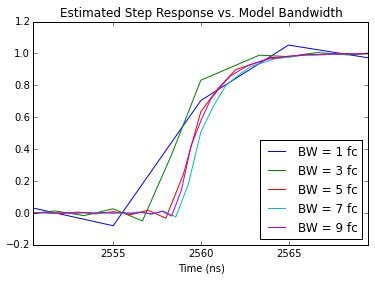

In [2]:
# Looking at the effect of finite model bandwidth on estimated step response.
%matplotlib inline
import matplotlib.pyplot as plt

from numpy     import arange, pi, real, cumsum, where
from numpy.fft import ifft, fftshift

# Change these, to modify simulation.
fc               = 100e6                                   # Corner frequency (Hz).
nsamps           = 1024                                    # Number of samples in processing vectors.
plot_timeunits   = 'ns'                                    # Currently, only 'ns' is supported.
plot_timescalers = {
    'ns' : 1.e9
}

# Don't change anything, below this line.
risetime        = 1. / (2. * pi * fc)
plot_halfwidth  = 6. * risetime
plot_timescaler = plot_timescalers[plot_timeunits]

edge_pos = 0.
for i in range(1, 10, 2):
    # Calculate the proper system vectors, for this loop iteration.
    maxf = i * fc
    t = arange(0, nsamps / (2. * maxf), 1. / (2. * maxf))  # Taking maxf = fNyquist (fN).
    f = arange(0, maxf * 2., maxf * 2. / nsamps) - maxf    # [-fN, fN), with nsamps elements.
    
    # Caclulate the: frequency response, impulse response, and step response.
    freq_resp = 1. / (1. + 1j * f / fc)                    # Single pole low pass response, in normalized freq. form.
    h = real(fftshift(ifft(fftshift(freq_resp))))          # The inner-most fftshift is critical!
    h /= sum(h)                                            # Ensures that step response ends at 1.0.
    s = cumsum(h)
    
    # Line up the edges of the different results, for plotting convenience.
    edge_ix = where(s > max(s) / 2.)[0][0]
    edge_time = t[edge_ix]
    if(edge_pos == 0.):                                    # We just got lucky that the first edge is also rightmost.
        edge_pos = edge_time
        time_shift = 0.
    else:
        time_shift = edge_time - edge_pos
    plt.plot((t - time_shift) * plot_timescaler, s, label="BW = {} fc".format(int(maxf / fc)))

plt.xlabel('Time (ns)')
plt.legend(loc='lower right')
plt.title('Estimated Step Response vs. Model Bandwidth')
plt.axis(xmin=((edge_pos - plot_halfwidth) * plot_timescaler), xmax=((edge_pos + plot_halfwidth) * plot_timescaler))


## Observations <a name="observations"/>

- At first, I thought the jaggedness of the "BW = 1 fc" curve was due to an insufficient number of samples in the signal processing vector. However, increasing *nsamps* eight fold did not change the nature of the plot! Then, I remembered that the time domain resolution is a property of only the maximum frequency considered:

$$
\Delta{t} = \frac{1}{2f_{MAX}} \qquad (1)
$$

- As expected, changing the value of *fc* does not change the nature of the plot, but only the magnitude of its horizontal axis. In particular, it does not change the point of diminishing returns, regarding model bandwidth. (See, below.)

## Conclusion <a name="conclusion"/>

Judging from the results, above, it appears that a model bandwidth, at least, 5x the channel bandwidth is sufficient to get a reasonably accurate estimate of the channel step response. Beyond that, we see diminishing returns on our investment in increased model bandwidth.

### Suggestions for Further Investigation

1. Try more complex channel responses.
1. Try making the signal vector, in the Python code, have constant frequency resolution, rather than constant length.

## Acknowledgements <a name="acknowledgements"/>

I'd like to thank [Yuriy Shlepnev](shlepnev@simberian.com) for engaging me on this topic, and for his helpful advice, regarding improvements to my [PyBERT tool](https://github.com/capn-freako/PyBERT/wiki).
